In [1]:
import numpy as np #alloys numpy arrays to be used
import matplotlib as mpl #see next comment
import matplotlib.pyplot as plt #allows use of plt. to plot figures
import pandas as pd
import networkx as nx #https://networkx.readthedocs.io/en/stable/index.html  #Aric A. Hagberg, Daniel A. Schult and Pieter J. Swart, “Exploring network structure, dynamics, and function using NetworkX”, in Proceedings of the 7th Python in Science Conference (SciPy2008), Gäel Varoquaux, Travis Vaught, and Jarrod Millman (Eds), (Pasadena, CA USA), pp. 11–15, Aug 2008
import os
%matplotlib inline

In [2]:
Header = ["scale", "id", "desc_scale", "desc_id", "num_prog", "pid", "upid", "desc_pid", "phantom", "sam_mvir", "mvir", "rvir", "rs", "vrms", "mmp", "scale_of_last_MM", "vmax", "x", "y", "z", "vx", "vy", "vz", "Jx", "Jy", "Jz", "Spin", "Breadth_first_ID", "Depth_first_ID", "Tree_root_ID", "Orig_halo_ID", "Snap_num", "Next_coprogenitor_depthfirst_ID", "Last_progenitor_depthfirst_ID", "Last_mainleaf_depthfirst_ID", "Tidal_Force", "Tidal_ID", "Rs_Klypin", "Mvir_all", "M200b", "M200c", "M500c", "M2500c", "Xoff", "Voff", "Spin_Bullock", "b_to_a", "c_to_a", "Ax", "Ay", "Az", "b_to_a500c", "c_to_a500c", "Ax500c", "Ay500c", "Az500c", "T/|U|", "M_pe_Behroozi", "M_pe_Diemer" ]

Finds the first merger tree above a given size

In [3]:
Size = 12
Files = os.listdir("/data/B-P50Mpc/Processed")
for File in Files:
    df = pd.read_csv("/data/B-P50Mpc/Processed/%s" %(File), delim_whitespace = True, names = Header)
    if(np.log10(df[df.scale == 1.00231].M200c[0])>Size):
        print(File)
        break

/home/pg1g15/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


Tree2812608373.dat


In [4]:
df = pd.read_csv("/data/B-P50Mpc/Processed/Tree2812608373.dat", delim_whitespace = True, names = Header)

In [5]:
df.M200c = np.log10(df.M200c) #turns m200c into a log10 m200c

/home/pg1g15/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


In [6]:
print(df.loc[:,['id','scale','M200c', 'upid', 'mmp', 'desc_id']]) #prints the things we care about from the DF

              id    scale      M200c        upid  mmp     desc_id
0     2812608373  1.00231  12.113275          -1    1          -1
1     2799561620  0.99472  12.110825          -1    1  2812608373
2     2786306286  0.98712  12.110421          -1    1  2799561620
3     2772838778  0.97953  12.113643          -1    1  2786306286
4     2759380849  0.97193  12.114377          -1    1  2772838778
5     2745876548  0.96434  12.111699          -1    1  2759380849
6     2745876549  0.96434   9.468997  2745876548    0  2759380849
7     2732311918  0.95675  12.110994          -1    1  2745876548
8     2732311920  0.95675   9.468997  2732311918    1  2745876549
9     2718719573  0.94915  12.104590          -1    1  2732311918
10    2718719575  0.94915   9.721720  2718719573    1  2732311920
11    2705087490  0.94156  12.100543          -1    1  2718719573
12    2705087492  0.94156   9.770019  2705087490    1  2718719575
13    2691412469  0.93397  12.099197          -1    1  2705087490
14    2691

In [7]:
grouped = df.groupby('scale') # creates and prints a grouped version of the dataframe
for name, group in grouped:
    print(group.loc[:,['id','scale','M200c', 'upid', 'mmp', 'desc_id']])

          id    scale     M200c  upid  mmp  desc_id
2625  686934  0.07587  8.889206    -1    1  1021247
           id    scale     M200c  upid  mmp  desc_id
2624  1021247  0.07812  8.792301    -1    1  1527603
           id    scale     M200c  upid  mmp  desc_id
2623  1527603  0.08037  8.792301    -1    1  2250427
           id    scale    M200c  upid  mmp  desc_id
2622  2250427  0.08262  9.36633    -1    1  3243326
           id  scale     M200c  upid  mmp  desc_id
2620  3243325  0.086  9.269420    -1    1  4565434
2621  3243326  0.086  9.144481    -1    1  4565435
           id    scale     M200c  upid  mmp  desc_id
2617  4565434  0.08937  9.304189    -1    1  6272738
2618  4565435  0.08937  9.551962    -1    1  6272739
2619  4565437  0.08937  9.231622    -1    1  6272741
           id    scale     M200c  upid  mmp  desc_id
2614  6272738  0.09275  9.588182    -1    1  8421422
2615  6272739  0.09275  9.637400    -1    1  8421424
2616  6272741  0.09275  9.394364    -1    1  8421426
   

             id    scale      M200c       upid  mmp    desc_id
1428  730349425  0.29862  11.395449         -1    1  753107880
1429  730349426  0.29862   9.035350  730349432    1  753107881
1430  730349427  0.29862   9.304189         -1    1  753107882
1431  730349428  0.29862   9.204482         -1    1  753107883
1432  730349430  0.29862  10.109309  730349436    1  753107885
1433  730349432  0.29862  11.057704  730349425    1  753107887
1434  730349433  0.29862   9.420682  730349425    1  753107888
1435  730349434  0.29862  10.203087         -1    1  753107889
1436  730349435  0.29862   9.445511         -1    1  753107890
1437  730349436  0.29862  10.766576         -1    1  753107891
1438  730349437  0.29862  10.185882         -1    1  753107892
1439  730349438  0.29862   9.190248         -1    1  753107893
1440  730349439  0.29862   9.420682         -1    1  753107894
1441  730349440  0.29862   9.468997         -1    1  753107895
1442  730349441  0.29862   9.512458         -1    1  75

             id    scale      M200c        upid  mmp     desc_id
299  1955294722  0.60743  12.026819          -1    1  1972417909
300  1955294723  0.60743   9.093317  1955294722    1  1972417910
301  1955294724  0.60743  10.181472  1955294722    1  1972417911
302  1955294726  0.60743   9.605208  1955294722    1  1972417913
303  1955294729  0.60743   9.144481          -1    1  1972417916
304  1955294730  0.60743   9.621602  1955294722    1  1972417917
305  1955294731  0.60743   8.968390          -1    1  1972417918
306  1955294732  0.60743   9.695385  1955294722    1  1972417919
307  1955294733  0.60743  10.087852  1955294722    1  1972417920
308  1955294734  0.60743   9.035350          -1    1  1972417921
309  1955294735  0.60743   9.532665          -1    1  1972417922
310  1955294736  0.60743  10.219611  1955294722    1  1972417923
             id   scale      M200c        upid  mmp     desc_id
287  1972417909  0.6125  12.031045          -1    1  1989460143
288  1972417910  0.6125   8

Function to correctly postion nodes in higherarchical tree

https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209#29597209?newreg=dcff13a7effb4b1985b768cbcebadc66

Function to define the Main Progenitor

Function to define Sub(sub)-halos

Function to calculate the doubblecount in mass

In [8]:
"""def hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, 
                  pos = None, parent = None):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node of current branch
       width: horizontal space allocated for this branch - avoids overlap with other branches
       vert_gap: gap between levels of hierarchy
       vert_loc: vertical location of root
       xcenter: horizontal location of root
       pos: a dict saying where all nodes go if they have been assigned
       parent: parent of this branch.'''
    if pos == None:
        pos = {root:(xcenter,vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    neighbors = G.neighbors(root)
    if parent != None:
        neighbors.remove(parent)
    if len(neighbors)!=0:
        dx = width/len(neighbors) 
        nextx = xcenter - width/2 - dx/2
        for neighbor in neighbors:
            nextx += dx
            pos = hierarchy_pos(G,neighbor, width = dx, vert_gap = vert_gap, 
                                vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, 
                                parent = root)
    return pos"""


def hierarchy_pos(G, root, levels=None, width=1., height=1.):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node
       levels: a dictionary
               key: level number (starting from 0)
               value: number of nodes in this level
       width: horizontal space allocated for drawing
       height: vertical space allocated for drawing'''
    TOTAL = "total"
    CURRENT = "current"
    def make_levels(levels, node=root, currentLevel=0, parent=None):
        """Compute the number of nodes for each level
        """
        if not currentLevel in levels:
            levels[currentLevel] = {TOTAL : 0, CURRENT : 0}
        levels[currentLevel][TOTAL] += 1
        neighbors = G.neighbors(node)
        if parent is not None:
            neighbors.remove(parent)
        for neighbor in neighbors:
            levels =  make_levels(levels, neighbor, currentLevel + 1, node)
        return levels

    def make_pos(pos, node=root, currentLevel=0, parent=None, vert_loc=0):
        dx = 1/levels[currentLevel][TOTAL]
        left = dx/2
        pos[node] = ((left + dx*levels[currentLevel][CURRENT])*width, vert_loc)
        levels[currentLevel][CURRENT] += 1
        neighbors = G.neighbors(node)
        if parent is not None:
            neighbors.remove(parent)
        for neighbor in neighbors:
            pos = make_pos(pos, neighbor, currentLevel + 1, node, vert_loc-vert_gap)
        return pos
    if levels is None:
        levels = make_levels({})
    else:
        levels = {l:{TOTAL: levels[l], CURRENT:0} for l in levels}
    vert_gap = height / (max([l for l in levels])+1)
    return make_pos({})

def DefineMPB(G, root, OnBranch = True, Parent = None, MPB = []):
    neighbors = G.neighbors(root)
    if Parent != None:
        neighbors.remove(Parent)
    if len(neighbors)!=0:
        for i in neighbors:
            if ((MergerTree.node[i]['mmp'] == 1) and OnBranch):
                nx.set_node_attributes(G, 'MPB', {i: 1})
                nx.set_node_attributes(G, 'color', {i: 'blue'})
                MPB.append(i)
                MPB = DefineMPB(G, i, Parent = root, MPB = MPB)
            else:
                nx.set_node_attributes(G, 'MPB', {i: 0})
                nx.set_node_attributes(G, 'color', {i: 'red'})
                DefineMPB(G, i, OnBranch = False, Parent = root)
    return MPB
                
def DefineSubHalos(G, root, Parent = None, OnBranch = True, SubSub = False):
    neighbors = G.neighbors(root)
    if Parent != None:
        neighbors.remove(Parent)
    if len(neighbors)!=0:
        for i in neighbors:
            if ((MergerTree.node[i]['upid'] != -1) and OnBranch):
                nx.set_node_attributes(G, 'SubHalo', {i: 1})
                if MergerTree.node[i]['upid'] != MergerTree.node[i]['pid'] and SubSub:
                    nx.set_node_attributes(G, 'color', {i: 'green'})
                else:
                    nx.set_node_attributes(G, 'color', {i: 'yellow'})
                DefineSubHalos(G, i, Parent = root, OnBranch = True)
            elif (MergerTree.node[i]['MPB'] == 1):
                nx.set_node_attributes(G, 'SubHalo', {i: 0})
                DefineSubHalos(G, i, Parent = root, OnBranch = True)
            else:                
                DefineSubHalos(G, i, Parent = root, OnBranch = False)
                nx.set_node_attributes(G, 'SubHalo', {i: 0})
                
def CountDCM(G, root, Parent = None, OnBranch = True, MassAtMerge = None, Doubble_Count = [], MaxDepth = None, Depth = None):
    
    if Depth != None:
        Depth += 1
    
    if (MaxDepth == None) or (MaxDepth >= Depth):
        #Finds the adjcent nodes and removes the parent
        neighbors = G.neighbors(root)
        if Parent != None:
            neighbors.remove(Parent)


        if len(neighbors)!=0:
            for i in neighbors:
                if ((MergerTree.node[i]['SubHalo'] == 1) and OnBranch):

                    if len(neighbors) == 1:
                        if MassAtMerge == None:
                            Doubble_Count = CountDCM(G, i, Parent = root, MassAtMerge = MergerTree.node[i]['M200c'], Doubble_Count = Doubble_Count, MaxDepth = MaxDepth, Depth = Depth)
                        else:
                            Doubble_Count = CountDCM(G, i, Parent = root, MassAtMerge = MassAtMerge, Doubble_Count = Doubble_Count, MaxDepth = MaxDepth, Depth = Depth)
                    else:
                        if MassAtMerge == None:
                            Doubble_Count = CountDCM(G, i, Parent = root, MassAtMerge = MergerTree.node[i]['M200c'], Doubble_Count = Doubble_Count, MaxDepth = MaxDepth, Depth = Depth)
                        else:
                            if MergerTree.node[i]['M200c'] > MassAtMerge:
                                Doubble_Count.append(np.log10(np.power(10, MergerTree.node[i]['M200c']) - np.power(10, MassAtMerge)))
                            Doubble_Count = CountDCM(G, i, Parent = root, Doubble_Count = Doubble_Count, MaxDepth = MaxDepth, Depth = Depth)

                elif((MergerTree.node[i]['SubHalo'] == 0) and OnBranch and MassAtMerge != None):
                    if MergerTree.node[i]['M200c'] > MassAtMerge:
                        Doubble_Count.append(np.log10(np.power(10, MergerTree.node[i]['M200c']) - np.power(10, MassAtMerge)))            
                else:
                    Doubble_Count = CountDCM(G, i, Parent = root, Doubble_Count = Doubble_Count, MaxDepth = MaxDepth, Depth = Depth)

        elif(MassAtMerge != None):
            if MergerTree.node[root]['M200c'] > MassAtMerge:
                Doubble_Count.append(np.log10(np.power(10, MergerTree.node[root]['M200c']) - np.power(10, MassAtMerge)))
    elif(MassAtMerge != None):
        if MergerTree.node[root]['M200c'] > MassAtMerge:
            Doubble_Count.append(np.log10(np.power(10, MergerTree.node[root]['M200c']) - np.power(10, MassAtMerge)))
    return Doubble_Count


def RemoveDCM(G, root, MPB, Depth, Parent = None, OnBranch = True, MassAtMerge = None, Doubble_Count = []):
    
    #Finds the adjcent nodes and removes the parent
    neighbors = G.neighbors(root)
    if Parent != None:
        neighbors.remove(Parent)


    if len(neighbors)!=0:
        for i in neighbors:
            if ((MergerTree.node[i]['SubHalo'] == 1) and OnBranch):

                if len(neighbors) == 1:
                    if MassAtMerge == None:
                        Doubble_Count = RemoveDCM(G, i, MPB, Depth+1, Parent = root, MassAtMerge = MergerTree.node[i]['M200c'], Doubble_Count = Doubble_Count)
                    else:
                        Doubble_Count = RemoveDCM(G, i, MPB, Depth+1, Parent = root, MassAtMerge = MassAtMerge, Doubble_Count = Doubble_Count)
                else:
                    if MassAtMerge == None:
                        Doubble_Count = RemoveDCM(G, i, MPB, Depth+1, Parent = root, MassAtMerge = MergerTree.node[i]['M200c'], Doubble_Count = Doubble_Count)
                    else:
                        if MergerTree.node[i]['M200c'] > MassAtMerge:
                            Doubble_Count.append(np.log10(np.power(10, MergerTree.node[i]['M200c']) - np.power(10, MassAtMerge)))
                        Doubble_Count = RemoveDCM(G, i, MPB, Depth+1, Parent = root, Doubble_Count = Doubble_Count)

            elif((MergerTree.node[i]['SubHalo'] == 0) and OnBranch and MassAtMerge != None):
                if MergerTree.node[i]['M200c'] > MassAtMerge:
                    Doubble_Count.append(np.log10(np.power(10, MergerTree.node[i]['M200c']) - np.power(10, MassAtMerge)))            
            else:
                Doubble_Count = RemoveDCM(G, i, MPB, Depth+1, Parent = root, Doubble_Count = Doubble_Count)

    elif(MassAtMerge != None):
        if MergerTree.node[root]['M200c'] > MassAtMerge:
            Doubble_Count.append(np.log10(np.power(10, MergerTree.node[root]['M200c']) - np.power(10, MassAtMerge)))
    
    if len(neighbors) > 1:
        Doubble_Count = []
        nx.set_node_attributes(G, 'M200cCor', { MPB[Depth]: MergerTree.node[MPB[Depth]]['M200c']} )
    else:
        MergerTree.node[MPB[Depth]]['M200c'] = np.log10(np.power(10, MergerTree.node[MPB[Depth]]['M200c']) - np.sum(np.power(10, Doubble_Count)))
        nx.set_node_attributes(G, 'M200cCor', { MPB[Depth]: np.log10(np.power(10, MergerTree.node[MPB[Depth]]['M200c']) - np.sum(np.power(10, Doubble_Count))) } )
    return Doubble_Count

def MakePosition(G, root, MPB, Depth, pos = None, Parent = None):
    if pos == None:
        pos = {root:((MergerTree.node[root]['M200c'] - MergerTree.node[MPB[Depth]]['M200c']),(1/MergerTree.node[root]['scale'])-1)}

    #Finds the adjcent nodes and removes the parent     
    neighbors = G.neighbors(root)
    if Parent != None:
        neighbors.remove(Parent)
    
    #pos[root] = ((np.nan_to_num(MergerTree.node[root]['M200c'] - MergerTree.node[MPB[Depth]]['M200c'])),(1/MergerTree.node[root]['scale'])-1)
    pos[root] = ((np.nan_to_num(MergerTree.node[root]['M200c'] - MergerTree.node[2812608373]['M200c'])),(1/MergerTree.node[root]['scale'])-1)
    if len(neighbors)!=0:
        for i in neighbors:                                
            pos = MakePosition(G, i, MPB, Depth + 1, pos = pos, Parent = root)
    return pos

Reads DF to create network 

In [9]:
SF = 0.25
DF = df[df.scale > SF]
MergerTree = nx.from_pandas_dataframe(DF.drop(0), "id", "desc_id", edge_attr = "mmp", create_using = nx.Graph())
nx.set_node_attributes(MergerTree, 'scale', pd.Series(DF.scale.values, index=DF.id).to_dict())
nx.set_node_attributes(MergerTree, 'M200c', pd.Series(DF.M200c.values, index=DF.id).to_dict())
nx.set_node_attributes(MergerTree, 'mmp', pd.Series(DF.mmp.values, index=DF.id).to_dict())
nx.set_node_attributes(MergerTree, 'upid', pd.Series(DF.upid.values, index=DF.id).to_dict())
nx.set_node_attributes(MergerTree, 'pid', pd.Series(DF.pid.values, index=DF.id).to_dict())

In [10]:
#sets the colors and MP/SUB properties of the halos
MPB = DefineMPB(MergerTree, 2812608373, MPB = [2812608373])
DefineSubHalos(MergerTree, 2812608373)

#calculates the doubble count of mass
Out = CountDCM(MergerTree, 2812608373, Doubble_Count= [])
print(Out)
print(np.log10(np.sum(np.power(10, np.array(Out)))))

#Removes the doubble count
Morig = [MergerTree.node[n]['M200c'] for n in MPB]
RemoveDCM(MergerTree, 2812608373, MPB, 0, Doubble_Count= [])
Mcorr = [MergerTree.node[n]['M200c'] for n in MPB]
#Mcorr = [MergerTree.node[n]['M200cCor'] for n in MPB]
Mdiff = np.log10(np.power(10, Morig) - np.power(10, Mcorr))
print(np.column_stack((Morig,Mcorr,Mdiff)))


[9.9145123984804027, 9.3042750504771359, 9.6526330680831087, 9.2694265437109653, 9.1902476330381955, 11.101405413707115, 9.9827233876685373, 10.243325828517802, 9.8978469315795738, 8.9683895418470705, 9.26941953751105, 9.0933271107443936, 8.7923216363515717, 9.4206817177038502, 8.4913616938342624, 9.7343276876893636, 10.724267675287978, 10.144468345157147, 10.768874790118874, 10.104063535984601, 9.1902476330381955, 8.6673595461830892, 10.082329301187027, 9.5124575861973426]
11.5418495456
[[ 12.11327469  12.11327469         -inf]
 [ 12.11082531  12.11082531         -inf]
 [ 12.11042135  12.11042135         -inf]
 [ 12.11364258  12.11364258         -inf]
 [ 12.11437743  12.11437743         -inf]
 [ 12.11169928  12.1106051    9.51245759]
 [ 12.11099352  12.10989755   9.51245759]
 [ 12.10458953  12.10347726   9.51245759]
 [ 12.10054285  12.09942016   9.51245759]
 [ 12.09919706  12.09807088   9.51245759]
 [ 12.09656244  12.0954294    9.51245759]
 [ 12.09159662  12.09045053   9.51245759]
 [ 

/home/pg1g15/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10


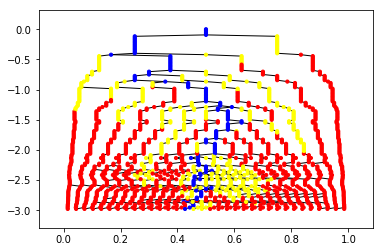

In [34]:
Redshift = (1/SF) -1
#Sets Attributes of root
nx.set_node_attributes(MergerTree, 'color', {2812608373: 'blue'})

#makes color mapping for plotting hte nodes
nodes = MergerTree.nodes()
colors = [MergerTree.node[n]['color'] for n in nodes]

#makes the graph area
fig = plt.figure()
fig.set_axes
#plt.ylim(Redshift,0)
#plt.xlim(0, -3)
ax = fig.add_axes()

#Makes the positioning of the nodes
pos = hierarchy_pos(MergerTree, 2812608373, height = 3) #2nd input is the root (MP at z = 0)
#pos = MakePosition(MergerTree, 2812608373, MPB, 0)
#'draws' the graph
nx.draw_networkx(MergerTree, pos = pos, nodelist = nodes, node_color = colors, with_labels = False, node_size = 10, ax = ax)

In [13]:
z = [((1/MergerTree.node[n]['scale'])-1) for n in MPB]

[]

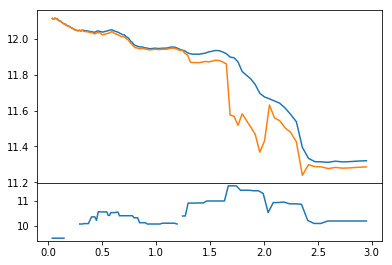

In [14]:
#Mdiff[Mdiff<0] = 0

#PLOT
fig1 = plt.figure(1)
#Plot Data-model
frame1=fig1.add_axes((.1,.3,.8,.6))
#xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
plt.plot(z,Morig)
plt.plot(z,Mcorr)
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.plot()

#Residual plot
frame2=fig1.add_axes((.1,.1,.8,.2))  
plt.plot(z,Mdiff)
plt.plot()

In [30]:
pd.DataFrame([x[1] for x in MergerTree.nodes(data = True)], index=[x[0] for x in MergerTree.nodes(data = True)]).reset_index()

,index,M200c,M200cCor,MPB,SubHalo,color,mmp,pid,scale,upid
0,2.745877e+09,12.110605,12.109508,1.0,0.0,blue,1,-1,0.96434,-1
1,2.745877e+09,9.468997,NaN,0.0,1.0,yellow,0,2745876548,0.96434,2745876548
2,1.706402e+09,11.943437,11.937415,1.0,0.0,blue,1,-1,0.53656,-1
3,1.706402e+09,9.144481,NaN,0.0,0.0,red,1,1706401866,0.53656,1706401866
4,1.706402e+09,9.770019,NaN,0.0,0.0,red,1,-1,0.53656,-1
5,1.706402e+09,9.394364,NaN,0.0,1.0,yellow,1,1706401866,0.53656,1706401866
6,1.706402e+09,10.540480,NaN,0.0,1.0,yellow,1,1706401866,0.53656,1706401866
7,1.706402e+09,9.695385,NaN,0.0,0.0,red,1,-1,0.53656,-1
8,1.706402e+09,9.420682,NaN,0.0,0.0,red,1,-1,0.53656,-1
9,1.706402e+09,9.667360,NaN,0.0,0.0,red,1,-1,0.53656,-1


In [25]:
A = MergerTree.nodes(data = True)

In [26]:
A

[(2745876548.0,
  {'M200c': 12.11060509549791,
   'M200cCor': 12.109508149723695,
   'MPB': 1,
   'SubHalo': 0,
   'color': 'blue',
   'mmp': 1,
   'pid': -1,
   'scale': 0.96433999999999997,
   'upid': -1}),
 (2745876549.0,
  {'M200c': 9.4689968090596022,
   'MPB': 0,
   'SubHalo': 1,
   'color': 'yellow',
   'mmp': 0,
   'pid': 2745876548,
   'scale': 0.96433999999999997,
   'upid': 2745876548}),
 (1706401866.0,
  {'M200c': 11.943436639094882,
   'M200cCor': 11.93741542454608,
   'MPB': 1,
   'SubHalo': 0,
   'color': 'blue',
   'mmp': 1,
   'pid': -1,
   'scale': 0.53656000000000004,
   'upid': -1}),
 (1706401871.0,
  {'M200c': 9.1444808009027501,
   'MPB': 0,
   'SubHalo': 0,
   'color': 'red',
   'mmp': 1,
   'pid': 1706401866,
   'scale': 0.53656000000000004,
   'upid': 1706401866}),
 (1706401872.0,
  {'M200c': 9.7700194297376868,
   'MPB': 0,
   'SubHalo': 0,
   'color': 'red',
   'mmp': 1,
   'pid': -1,
   'scale': 0.53656000000000004,
   'upid': -1}),
 (1706401873.0,
  {'M200c